In [1]:
import sklearn.metrics as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from tqdm import tqdm

from matplotlib.colors import ListedColormap
from sklearn.datasets import load_breast_cancer, make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')
850


<BarContainer object of 4 artists>

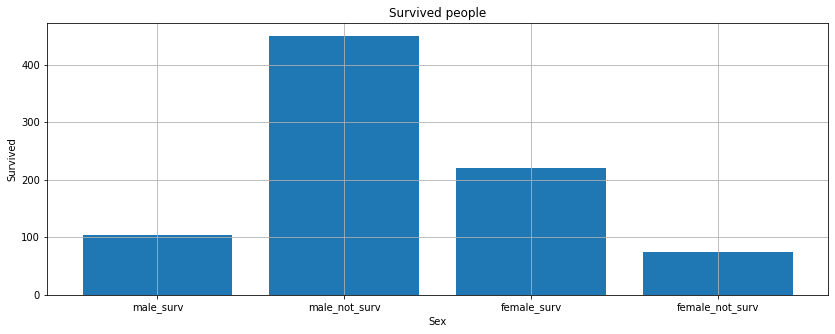

In [2]:
###СМЕРТИ-ПОЛ###
df_train = pd.read_csv("train.csv")
print(df_train.columns)
print(df_train.shape[0])
sex = ['male_surv','male_not_surv', 'female_surv', 'female_not_surv']

surv_male = df_train[df_train.Sex == 'male'][['Survived']].Survived.sum()
not_surv_male = df_train[(df_train.Sex == 'male') & (df_train.Survived == 0)][['Sex']].count()
surv_female = df_train[df_train.Sex == 'female'][['Survived']].Survived.sum()
not_surv_female = df_train[(df_train.Sex == 'female') & (df_train.Survived == 0)][['Sex']].count()

survived = [surv_male, not_surv_male, surv_female, not_surv_female]

fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('Sex')
ax1.set_ylabel('Survived')
ax1.set_title('Survived people')
ax1.grid()
ax1.bar(sex, survived) 

<BarContainer object of 6 artists>

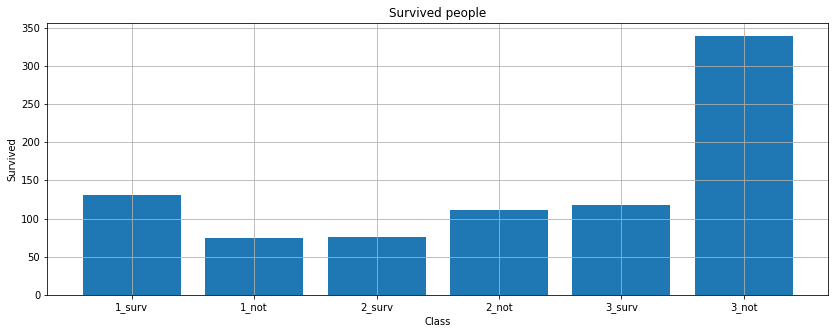

In [3]:
###СМЕРТИ-КЛАСС###
cls = ['1_surv', '1_not', '2_surv', '2_not', '3_surv', '3_not']

surv_cls_1 = df_train[df_train.Pclass == 1][['Survived']].Survived.sum()
surv_cls_2 = df_train[df_train.Pclass == 2][['Survived']].Survived.sum()
surv_cls_3 = df_train[df_train.Pclass == 3][['Survived']].Survived.sum()

not_surv_cls_1 = df_train[(df_train.Pclass == 1) & (df_train.Survived == 0)][['Pclass']].count()
not_surv_cls_2 = df_train[(df_train.Pclass == 2) & (df_train.Survived == 0)][['Pclass']].count()
not_surv_cls_3 = df_train[(df_train.Pclass == 3) & (df_train.Survived == 0)][['Pclass']].count()

survived = [surv_cls_1, not_surv_cls_1, surv_cls_2, not_surv_cls_2, surv_cls_3, not_surv_cls_3]

fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('Class')
ax1.set_ylabel('Survived')
ax1.set_title('Survived people')
ax1.grid()
ax1.bar(cls, survived) 

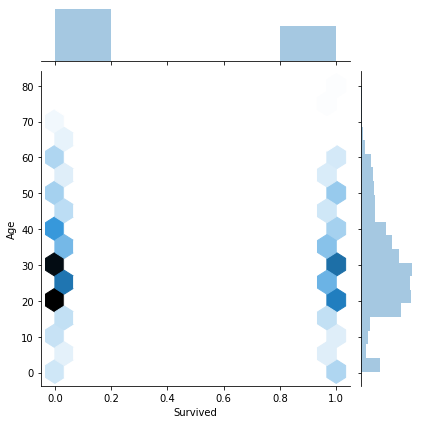

In [4]:
###СМЕРТИ-ВОЗРАСТ###
sns.jointplot(x='Survived', y='Age', data=df_train, kind = 'hex',gridsize=15)

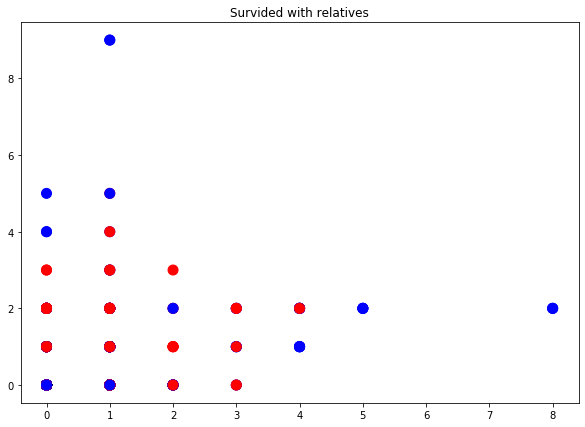

In [5]:
###СМЕРТИ-РОДСТВЕННИКИ###
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("Survided with relatives")
plt.scatter(df_train['SibSp'], df_train['Parch'], c=df_train['Survived'], cmap=colors, s=100)
plt.show()

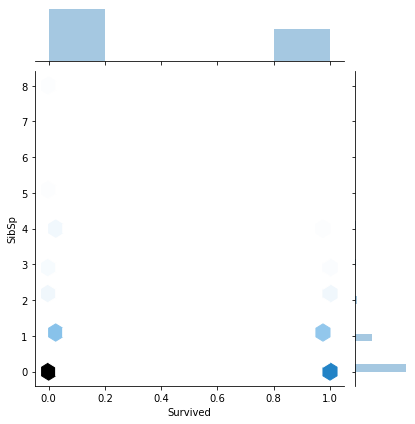

In [6]:
###СМЕРТИ-РОДСТВЕННИКИ###
sns.jointplot(x='Survived', y='SibSp', data=df_train, kind = 'hex',gridsize=20)

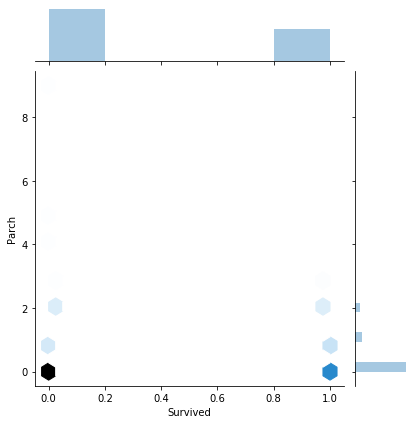

In [7]:
###СМЕРТИ-ДЕТИ###
sns.jointplot(x='Survived', y='Parch', data=df_train, kind = 'hex',gridsize=20)

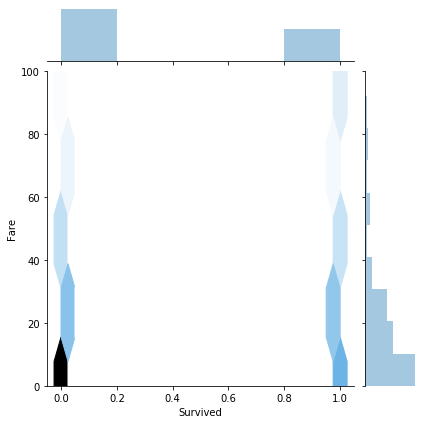

In [8]:
###СМЕРТИ-FARE###
sns.jointplot(x='Survived', y='Fare', data=df_train, kind = 'hex',gridsize=20, ylim=(0, 100))

In [9]:
###СМЕРТИ-КАЮТА###
df_train['Cabin'].value_counts().index

Index(['C23 C25 C27', 'D', 'B96 B98', 'E101', 'F4', 'B57 B59 B63 B66', 'C101',
       'B58 B60', 'B5', 'C2',
       ...
       'C55 C57', 'B22', 'B94', 'C123', 'C148', 'D49', 'A31', 'E68', 'A10',
       'C103'],
      dtype='object', length=138)

In [10]:
import warnings
warnings.filterwarnings("ignore")

random.seed(42)

df_test = pd.read_csv('test.csv')

In [11]:
def design_df(df):
    data = df[['Pclass', 'Sex', 'Age']]

    data['Relatives'] = df['Parch'] + df['SibSp']
    cls1 = data[data.Pclass == 1][['Age']].median().max()
    cls2 = data[data.Pclass == 2][['Age']].median().max()
    cls3 = data[data.Pclass == 3][['Age']].median().max()

    data.Age[data.Age.isnull() & (data.Pclass == 1)] = cls1
    data.Age[data.Age.isnull() & (data.Pclass == 2)] = cls2
    data.Age[data.Age.isnull() & (data.Pclass == 3)] = cls3

    data.Sex[data.Sex == 'male'] = 1
    data.Sex[data.Sex == 'female'] = 0
    #data.Embarked[data.Embarked == 'S'] = 2
    #data.Embarked[data.Embarked == 'Q'] = 1
    #data.Embarked[data.Embarked == 'C'] = 0
    #data.Fare[data.Fare.isnull()] = data.Fare.median()
    return data

In [12]:
### LOGREG ###
print(df_train.columns)


data = design_df(df_train)

target = df_train['Survived']

C_values = np.arange(1, 10000, 10)

best_score = 0
best_param = 0.1
best_model = None

early_stopping_rounds = 100 # кол-во кругов, после которого без прироста скора заканчивается работа
rounds_without_gain = 0

for C in tqdm(C_values):
    model = LogisticRegression(C=C, random_state=42)
    score = np.mean(cross_val_score(model, data, target, cv=5, scoring="accuracy"))
    
    if score > best_score:
        best_score = score
        best_model = model
        best_param = C
        rounds_without_gain = 0
    else:
        rounds_without_gain += 1
    if rounds_without_gain == early_stopping_rounds:
        print("Stopping with {}".format(early_stopping_rounds))
        break
        
print(f"Hyperparameters selection finished, best score - {best_score:0.4f} at C={best_param}")
print(best_model)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)
best_model.fit(X_train, y_train)
predictions = best_model.predict(X_test)
print(predictions)
print(sm.accuracy_score(y_test, predictions))


Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Survived'],
      dtype='object')


 10%|█         | 100/1000 [00:03<00:29, 30.27it/s]

Stopping with 100
Hyperparameters selection finished, best score - 0.7929 at C=21
LogisticRegression(C=21, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
[0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0
 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1
 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0]
0.8


In [13]:
test = design_df(df_test)
predictions = best_model.predict(test)
print(predictions)
submission = pd.DataFrame({"Survived": predictions}, columns=["Survived"])
print(submission.columns)
submission.index = df_test['PassengerId']
print(submission.tail())
submission.to_csv('submission.csv')

[1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0
 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0
 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1
 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 1
 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1
 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0
 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0
 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0]
Index(['Survived'], dtype='object')
             Survived
PassengerI

In [14]:
### KNN ###
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=20)
score = np.mean(cross_val_score(model, data, target, cv=5, scoring="accuracy"))
print(score)
model.fit(X_train, y_train)

predictions_knn = model.predict(X_test)
print(predictions_knn)
print(sm.accuracy_score(y_test, predictions_knn))

0.6988235294117647
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 0 1 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0]
0.7411764705882353


In [15]:
predictions_knn = model.predict(test)
print(sm.accuracy_score(predictions_knn, predictions))
submission_knn = pd.DataFrame({"Survived": predictions_knn}, columns=["Survived"])
submission_knn.index = df_test['PassengerId']
print(submission_knn.tail())
submission_knn.to_csv('submission_knn.csv')

0.7690631808278867
             Survived
PassengerId          
1242                0
246                 0
875                 1
893                 0
227                 0
